In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [2]:
import torch
import numpy as np
import random
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


class MovingMNIST(torch.utils.data.Dataset):
    """
    num_sequences: no of sequences to generate 
    sequence_lenght (T): no of frames in each sequence:20
    image size: Hightx width : 32x32
    Speed: Choose how pixels MNIST digit moves in next frame
    Digit: #Set digit 0-9 for a specific digit or enter any other number to generate all numbers 

    """

    def __init__(self, num_sequences=1000, sequence_length=20, image_size=32, digit_size=28, speed=2, digit=3):
        self.mnist = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
        self.num_sequences = num_sequences
        self.sequence_length = sequence_length
        self.image_size = image_size
        self.digit_size = digit_size
        self.speed = speed  # pixels/frame
        self.digit = digit

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        canvas_size = self.image_size #32x32 looks similiar as in paper increase if required
        frames = np.zeros((self.sequence_length, canvas_size, canvas_size), dtype=np.float32)

        # Select a random MNIST digit
        #digit_img, _ = self.mnist[random.randint(0, len(self.mnist) - 1)] #Random
        digit_img, label = self.mnist[random.randint(0, len(self.mnist) - 1)]

        if self.digit in range(0,10):
        # Uncomment the following line to select only a specific digit (e.g., 3) for testing
            while label != self.digit: digit_img, label = self.mnist[random.randint(0, len(self.mnist) - 1)]
            digit_img = digit_img.squeeze(0).numpy()

        else:
            digit_img = digit_img.squeeze(0).numpy()



        # Random direction: -1 (left) or +1 (right)
        #direction = random.choice([-1, 1]) direction controlled by the training
        

        direction = 1
        dx = direction * self.speed  # no of pixel left/right

        # Random start
        x = random.randint(0, canvas_size - 1)
        y = random.randint(0, canvas_size - self.digit_size)
        #y = (canvas_size - self.digit_size) // 2  # center vertically if needed

        for t in range(self.sequence_length):
            x_int = int(np.floor(x)) % canvas_size  # wrap x using modulo

            # Handle wrap-around drawing
            if x_int + self.digit_size <= canvas_size:
                # Fully inside canvas
                frames[t, y:y+self.digit_size, x_int:x_int + self.digit_size] += digit_img
            else:
                # Split across right and left border
                right_part = canvas_size - x_int
                left_part = self.digit_size - right_part

                # Right slice
                frames[t, y:y+self.digit_size, x_int:] += digit_img[:, :right_part]
                # Left slice
                frames[t, y:y+self.digit_size, :left_part] += digit_img[:, right_part:]

            x += dx  # move with wrapping

        frames = np.clip(frames, 0, 1)
        frames = torch.tensor(frames).unsqueeze(1)  # shape: (T, 1, H, W)
        return frames


torch.Size([20, 1, 32, 32])


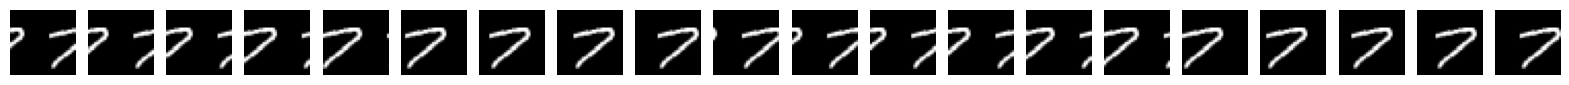

In [3]:
dataset = MovingMNIST(sequence_length=20, speed=3, digit=99) #Set digit 0-9 for a specific digit or enter any other number to generate all numbers
sequence = dataset[0]

print(sequence.shape)

def show_sequence(frames, title="Wrapped Digit Movement"):
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, len(frames), figsize=(len(frames), 1.5))
    for i, ax in enumerate(axes):
        ax.imshow(frames[i, 0], cmap="gray")
        ax.axis("off")
    #plt.suptitle(title)
    plt.show()

show_sequence(sequence, title="Digit Moves & Wraps Around") #Visualize the data 


In [4]:
# Generate data
X_train = MovingMNIST(num_sequences=10000,sequence_length=20, speed=1, digit=99) #Set digit 0-9 for a specific digit or enter any other number to generate all numbers
X_val = MovingMNIST(num_sequences=200, sequence_length=20, speed=3)

# Create data loaders
train_loader = DataLoader(X_train, batch_size=64, shuffle=True)
val_loader = DataLoader(X_val, batch_size=64, shuffle=False)

In [5]:
for batch in train_loader:
    sequence = batch
    print(sequence.shape)
    break
    

torch.Size([64, 20, 1, 32, 32])


In [6]:
def time_interval():
    """
    Choose a random t1 in [1,19]
    Choose a random dt between 1 and 4
    Choose random direction +/-1
    Compute t2 = t1 + dt * direction
    Clip t2 to stay within [0,20]
    """
    t1 = random.randint(1, 18)
    dt = random.randint(1, 4)
    direction = random.choice([-1, 1])
    direction = 1  # TODo: Try for both left and right 
    t2 = t1 + dt * direction

    # Border check: clip to [0, 20]
    if t2 < 0:
        t2 = 0
    elif t2 > 19:
        t2 = 19

    return t1, t2, direction


In [7]:
t1, t2, direction = time_interval()
print(t1)
print(t2)
print(direction)

16
19
1


In [8]:
#Sampling example used for loss and testing
for batch in train_loader:
    x = batch
    print(x.shape)
    print(x[:, 13, :,:,:].shape)
    break


torch.Size([64, 20, 1, 32, 32])
torch.Size([64, 1, 32, 32])


In [9]:
import torch
import torch.nn as nn

class Sampling(nn.Module):
    def __init__(self):
        super(Sampling, self).__init__()

    def forward(self, z_mean, z_log_var):
        eps = torch.randn_like(z_mean)
        return z_mean + eps * torch.exp(0.5 * z_log_var)


class Encoder(nn.Module):
    """
    Input: (B, T, 1, 32, 32)
    Output: (B, T, latent_dim)
    """
    def __init__(self, latent_dim, lstm_hidden_dim=256, num_layers=2, input_size = 1024, processed_x_size = 1024, bidirectional=False):
        super(Encoder, self).__init__()

        self.latent_dim = latent_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1
        self.input_size = input_size
        self.processed_x_size = processed_x_size


        # Flatten spatial dimensions
        self.flatten = nn.Flatten(start_dim=2)   # from (B, T, 1, 32, 32) to (B, T, 1024)

        self.fc1 = nn.Linear(input_size, processed_x_size)
        self.fc2 = nn.Linear(processed_x_size, processed_x_size)

        
        # LSTM directly on flattened pixels
        self.lstm = nn.LSTM(
            input_size=32*32,
            hidden_size=lstm_hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        # Latent mapping

        self.bt = nn.Linear(self.num_directions * lstm_hidden_dim, 32)
        self.z_mean_t = nn.Linear(self.num_directions * lstm_hidden_dim, latent_dim)
        self.z_log_var_t = nn.Linear(self.num_directions * lstm_hidden_dim, latent_dim)

        self.sampling = Sampling()

    def forward(self, x):
        # Flatten: (B, T, 1, 32, 32) -> (B, T, 1024)
        x = self.flatten(x)

        #x = torch.relu(self.fc1(x))
        #x = torch.relu(self.fc2(x))

        # LSTM
        lstm_out, _ = self.lstm(x)  # (B, T, hidden_dim * num_directions)
        bt = self.bt(lstm_out)
        # Latent variables
        z_mean = self.z_mean_t(lstm_out)
        z_log_var = self.z_log_var_t(lstm_out)
        zt = self.sampling(z_mean, z_log_var)

        return z_mean, z_log_var, zt, bt


In [10]:
class Decoder(nn.Module):
    """
    Latent variable to single frame reconstruction 
    Input:  (B, latent_dim)
    Output: (B, 1, 32, 32)
    """
    def __init__(self, latent_dim, lstm_hidden=256, num_layers=2, output_size=32*32):
        super(Decoder, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=latent_dim,
            hidden_size=lstm_hidden,
            num_layers=num_layers,
            batch_first=True
        )
        
        self.fc = nn.Linear(lstm_hidden, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # Add sequence dimension: (B, 1, latent_dim)
        z = z.unsqueeze(1)
        
        # Pass through LSTM
        lstm_out, _ = self.lstm(z)   # (B, 1, hidden)
        
        # Todo: Take last step or average
        
        x = lstm_out[:, -1, :]  #Take last step 
        #x = lstm_out.mean(dim=1)  #Take average       
        
        # Map to image space
        x = self.fc(x)               # (B, 1024)
        x = self.sigmoid(x)
        x = x.view(-1, 1, 32, 32)    # (B, 1, 32, 32)
        return x


In [11]:
class Smoothing(nn.Module):
    def __init__(self, latent_dim,  hidden_dim=128):
        super(Smoothing, self).__init__()

        #input_dim = latent_dim + 32 + 32 + 1  # z_t2 + b_t1 + b_t2 + delta_t
        input_dim = latent_dim + 32 + 32 + 1 + 1 # z_t2 + b_t1 + b_t2 + delta_t + direction

        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        ) #Activation function

        self.qs_mean_t1 = nn.Linear(hidden_dim, latent_dim)  # 81 → 15 64x15
        self.qs_log_var_t1 = nn.Linear(hidden_dim, latent_dim)  # 81 → 15 64x15
        #Add activations
        self.sampling = Sampling()

    def forward(self, smoothing_input):
        # smoothing_input shape: (batch, latent_dim + 32 + 32 + 1 + 1 )
        h = self.mlp(smoothing_input)
        qs_mean = self.qs_mean_t1(h)      # (batch, latent_dim)  # (64, 15)
        qs_log_var = self.qs_log_var_t1(h)  # (64, 15)
        qs_log_var = torch.clamp(qs_log_var, min=-10.0, max=10.0) # Clip log var for stability

        zt1 = self.sampling(qs_mean, qs_log_var)        # (batch, latent_dim)  # (64, 15)

        return zt1, qs_mean, qs_log_var #all have shape = (batch, latent_dim)

In [12]:
import torch
import torch.nn as nn

class Transition(nn.Module):
    def __init__(self, latent_dim, hidden_dim =128):
        super(Transition, self).__init__()
        #input_dim = latent_dim + 1  # z_t1 + delta_t
        input_dim = latent_dim + 1 + 1 # z_t1 + delta_t + direction


        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.pt_mean_t1 = nn.Linear(input_dim, latent_dim)
        self.pt_log_var_t1 = nn.Linear(input_dim, latent_dim)
        #Add activations

    def forward(self, transition_input):
        # transition_input shape: (batch, latent_dim + 1 + 1)

        transition_output = self.mlp(transition_input)
        pt_mean = self.pt_mean_t1(transition_input)      # (batch, latent_dim)
        pt_log_var = self.pt_log_var_t1(transition_input)
        pt_log_var = torch.clamp(pt_log_var, min=-10.0, max=10.0) # Clip log var for stability

        return pt_mean, pt_log_var

In [13]:
latent_dim = 15

In [14]:
## checking dimensions of the encoder Smoothing transition and Decoder

# Instantiate the model
encoder = Encoder(latent_dim=latent_dim).to(device)

# Set model to eval mode (optional for testing)
encoder.eval()

# Get one batch from the DataLoader
for batch in train_loader:
    x = batch.to(device)  # shape: [64, 20, 1, 32, 32]
    print("Input data shape:", x.shape)
    # Forward pass through encoder
    with torch.no_grad():  # disable gradient computation for testing
        z_mean, z_log_var, zt, bt = encoder(x)

    print("z_mean shape:", z_mean.shape)       # Expected: [64, 20, 15]
    print("z_log_var shape:", z_log_var.shape) # Expected: [64, 20, 15]
    print("zt shape:", zt.shape)               # Expected: [64, 20, 15]
    print("bt shape:", bt.shape)               # Expected: [64, 20, 32]

    smoothing = Smoothing(latent_dim=latent_dim).to(device)

    t1, t2, direction = time_interval()
    print("t1:", t1)
    print("t2:", t2)
    print("direction:", direction)
    bt1, bt2 = bt[:, t1, :], bt[:, t2, :]  #(64,32) each


    print("bt1 shape:", bt1.shape)
    print("bt2 shape:", bt2.shape)
    zt2 = zt[:, t2, :] #(64,15)

    print("zt2 shape:", zt2.shape)

    # dt as scalar difference
    dt_value = abs(t2 - t1)

    # Create as tensor on the same device
    dt = torch.full((bt1.shape[0], 1), dt_value, device=device, dtype=torch.float32)
    direction = torch.full((bt1.shape[0], 1), 1.0 if t2 > t1 else -1.0, device=device, dtype=torch.float32)

    # Concatenate
    smoothing_inputs = torch.cat((bt1, bt2, zt2, dt, direction), dim=-1)
    print("smoothing_inputs shape:", smoothing_inputs.shape)

    zt1, qs_mean, qs_log_var = smoothing(smoothing_inputs)
    print("zt1 shape:", zt1.shape)
    print("qs_mean shape:", qs_mean.shape)
    print("qs_log_var shape:", qs_log_var.shape)

    transition = Transition(latent_dim=latent_dim).to(device)

    trans_input = torch.cat((zt1, dt, direction), dim=-1) #(64, 15 + 1 + 1) = (64, 17)
    print("trans_input shape:", trans_input.shape)
    pt_mean, pt_log_var = transition(trans_input) #(64 x 15) each

    print("pt_mean shape:", pt_mean.shape)
    print("pt_log_var shape:", pt_log_var.shape)

    decoder_input = zt[:,15,:]
    print("decoder_input shape:", decoder_input.shape)
    
    decoder = Decoder(latent_dim=latent_dim).to(device)
    

    reconstruction = decoder(decoder_input)
    print("reconstruction shape:", reconstruction.shape)


    #Sampling the data

    sample_x = x[:,15,:,:,:]
    print("sample_x shape:", sample_x.shape)
    break  # just one batch


Input data shape: torch.Size([64, 20, 1, 32, 32])
z_mean shape: torch.Size([64, 20, 15])
z_log_var shape: torch.Size([64, 20, 15])
zt shape: torch.Size([64, 20, 15])
bt shape: torch.Size([64, 20, 32])
t1: 12
t2: 15
direction: 1
bt1 shape: torch.Size([64, 32])
bt2 shape: torch.Size([64, 32])
zt2 shape: torch.Size([64, 15])
smoothing_inputs shape: torch.Size([64, 81])
zt1 shape: torch.Size([64, 15])
qs_mean shape: torch.Size([64, 15])
qs_log_var shape: torch.Size([64, 15])
trans_input shape: torch.Size([64, 17])
pt_mean shape: torch.Size([64, 15])
pt_log_var shape: torch.Size([64, 15])
decoder_input shape: torch.Size([64, 15])
reconstruction shape: torch.Size([64, 1, 32, 32])
sample_x shape: torch.Size([64, 1, 32, 32])


In [15]:
#Beta Scheduling for KL loss 

def linear_beta_schedule(epoch, max_epochs, max_beta=1.0, min_beta=0.0):
    return min_beta + (max_beta - min_beta) * (epoch / max_epochs)
    #Max beta increase for string decoder 

def cyclic_beta_schedule(step, warmup_steps, beta_max = 1.0):
    factor = step // warmup_steps + 1
    if factor % 2 == 1: # odd means ramping up
       current_max = warmup_steps * factor
       normalized_step = 1 - (current_max - step) / warmup_steps
       beta = beta_max * normalized_step
    else: 
        beta = beta_max
    return beta

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import random

class VAE(nn.Module):
    def __init__(self, encoder, decoder, smoothing, transition, latent_dim, transition_matrix_A, prior_covariance, Markov_Prior=0):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim
        self.smoothing = smoothing
        self.transition = transition
        self.Markov_Prior = Markov_Prior

        self.A = transition_matrix_A  # shape: (latent_dim, latent_dim)
        self.cov = prior_covariance   # shape: (latent_dim,) or (latent_dim, latent_dim)

        # You can track losses using simple Python variables in your training loop
        self.total_loss = 0.0
        self.reconstruction_loss = 0.0
        self.kl_loss = 0.0

    def reset_loss_trackers(self):
        self.total_loss = 0.0
        self.reconstruction_loss = 0.0
        self.kl_loss = 0.0

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data, optimizer, beta, device):

      data = data.to(device)
      # print(f"Data shape: {data.shape}, dtype: {data.dtype}") # Debug print


      if self.Markov_Prior == 1:
          # === Markov Prior ===
          z_mean, z_log_var, z, bt = self.encoder(data)

          t1, t2, direction = time_interval()
          # Ensure t1 and t2 are within valid range
          T = data.shape[1]
          t1 = max(0, min(t1, T - 1))
          t2 = max(0, min(t2, T - 1))


          bt1, bt2 = bt[:, t1, :], bt[:, t2, :]  #(64,32) each
          zt2 = z[:, t2, :] #(64,15)
          dt = (t2 - t1) * torch.ones((bt1.shape[0], 1), device=device) #(64,1)
          direction_tensor = torch.full((data.size(0), 1), fill_value=direction, dtype=dt.dtype, device=device) #(64,1)


          smoothing_inputs = torch.cat((bt1, bt2, zt2, dt, direction_tensor), dim=-1) # (64, 80) → (64, 15)
          zt1, qs_mean, qs_log_var = self.smoothing(smoothing_inputs) #(64,15) each


          #A_pow = self.A.to(device) ** (t2 - t1)
          A_pow = torch.matrix_power(self.A, t2 - t1)
          pt_mean = zt1 @ A_pow.T   # (64, 15) @ (15, 15).T → (64, 15) Matrix multiplication
          pt_log_var = torch.log(self.cov) * A_poly(self.A, t2 - t1 - 1)

      else:
          # === Non-Markov ===
          z_mean, z_log_var, z, bt = self.encoder(data) #64x20x1x32x32 - 64x20x15

          #For debugging
          # print(f"z_mean shape: {z_mean.shape}, z_log_var shape: {z_log_var.shape}, z shape: {z.shape}, bt shape: {bt.shape}")

          t1, t2, direction = time_interval()

          #t2 = direction_of_time_interval(t1, t2)
          
          # Ensure t1 and t2 are within valid range
          T = data.shape[1]
          t1 = max(0, min(t1, T - 1))
          t2 = max(0, min(t2, T - 1))
          
          # print(f"Selected t1: {t1}, t2: {t2}, direction: {direction}") For debugging
          
          #Sample belief state from t1 and t2 and latent at t2
          bt1, bt2 = bt[:, t1, :], bt[:, t2, :]  #(64,32) each
          zt2 = z[:, t2, :] #(64,15)

          dt = torch.full((data.size(0), 1), t2 - t1, dtype=bt1.dtype, device=data.device) #(64,1)
          direction_tensor = torch.full((data.size(0), 1), fill_value=direction, dtype=dt.dtype, device=device)


          # print(f"bt1 shape: {bt1.shape}, bt2 shape: {bt2.shape}, zt2 shape: {zt2.shape}, dt shape: {dt.shape}, direction shape: {direction_tensor.shape}") For debugging


          smoothing_inputs = torch.cat((bt1, bt2, zt2, dt, direction_tensor), dim=-1)   #(64,81)
          # print(f"Smoothing inputs shape: {smoothing_inputs.shape}")
          zt1, qs_mean, qs_log_var = self.smoothing(smoothing_inputs)  #(64,15) each
          # print(f"zt1 shape: {zt1.shape}, qs_mean shape: {qs_mean.shape}, qs_log_var shape: {qs_log_var.shape}")


          trans_input = torch.cat((zt1, dt, direction_tensor), dim=-1) #(64, 15 + 1 + 1) = (64, 17)
          # print(f"Transition input shape: {trans_input.shape}")
          pt_mean, pt_log_var = self.transition(trans_input) #(64 x 15) each
          # print(f"pt_mean shape: {pt_mean.shape}, pt_log_var shape: {pt_log_var.shape}")


      # === Decoder ===
      reconstruction = self.decoder(zt2) #(64,15) - (64,1,32,32)
      target = data[:, t2, :] #(64,1,32,32)
      
      # --- Flatten for BCE ---
      batch_size = reconstruction.size(0)
      reconstruction = reconstruction.view(batch_size, -1)  # (64, 1024) for MNIST-like
      target = target.view(batch_size, -1)                  # (64, 1024)

      # Print min/max values for debugging 
      #print(f"Reconstruction min: {reconstruction.min().item()}, max: {reconstruction.max().item()}") 
      #print(f"Target min: {target.min().item()}, max: {target.max().item()}")


      # === Reconstruction Loss (Binary Cross Entropy) ===
      bce = F.binary_cross_entropy(reconstruction, target, reduction='sum') / (batch_size) #SCaing the loss add normalisa
      

      # -------------------------------------------------------------------------
      # === KL Divergence Terms (Stable VAE formula) ===
      # KL[q(z1|z2,b1) || p(z1)]  ~ smoothing posterior vs standard normal prior
      # -------------------------------------------------------------------------
      mu_zt1, logvar_zt1 = qs_mean, qs_log_var
      kl_smoothing_prior = -0.5 *torch.sum(
          1 + logvar_zt1 - mu_zt1.pow(2) - logvar_zt1.exp(),
          dim=1
      ).mean()
       

      # -------------------------------------------------------------------------
      # KL[q(z2|b2) || p(z2|z1)]  ~ posterior vs transition prior
      # -------------------------------------------------------------------------
      mu_post, logvar_post = z_mean[:, t2, :], z_log_var[:, t2, :]
      mu_prior, logvar_prior = pt_mean, pt_log_var

      kl_posterior_transition = 0.5 * torch.sum(
          logvar_prior - logvar_post
          + (logvar_post.exp() + (mu_post - mu_prior).pow(2)) / logvar_prior.exp()
          - 1,
          dim=1
      ).mean()

      #Total Kl
      total_kl = kl_smoothing_prior + kl_posterior_transition

      #Total Loss
      total_loss = bce + beta*total_kl
      
      #Backward pass and optimization
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()

      # metrics
      return {
          'loss': total_loss.item(),
          'reconstruction_loss': bce.item(),
          'kl_smoothing_prior': kl_smoothing_prior.item(),
          'kl_posterior_transition': kl_posterior_transition.item()
          }

In [17]:
# Instances of the network classes

encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)

smoothing = Smoothing(latent_dim)
transition = Transition(latent_dim)


In [18]:
A_diag = torch.eye(15, dtype=torch.float32, device=device)  # or torch.rand(3, 3)
cov = torch.ones(15, dtype=torch.float32, device=device)    # or torch.eye(3)

In [19]:
# Testing the Network 
import math

beta = 0
initial_lr =  5e-4

vae = VAE(encoder, decoder, smoothing, transition, latent_dim=latent_dim, transition_matrix_A=A_diag, prior_covariance=torch.ones(latent_dim), Markov_Prior=0)       # construct the model
vae.to(device)        # move to GPU/CPU
vae.train()           # <- do not remove or redefine this!
vae.reset_loss_trackers()

optimizer = torch.optim.Adam(vae.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

for batch in train_loader:
    x = batch.to(device)
    
    metrics = vae.train_step(x, optimizer, beta, device)
    print(metrics)
    print(x.shape)
    break #comment if looses are okay 
#if no error the dimensions are okay; use print above to check for nans or irregular values of losses   

{'loss': 709.4208374023438, 'reconstruction_loss': 709.4208374023438, 'kl_smoothing_prior': 0.05718327686190605, 'kl_posterior_transition': 4.231775283813477}
torch.Size([64, 20, 1, 32, 32])


In [20]:
import os
import torch

num_epochs = 2 # Trained for 4000 epochs 
vae.train() 
step = 20
warmup_epochs = 20

# Create checkpoint directory
checkpoint_dir = "checkpoint_normal_VAE"
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialize lists to store losses for plotting
loss_history = []
bce_history = []
kl_smooth_history = []
kl_post_history = []

for epoch in range(num_epochs):
    total_loss = 0.0
    total_bce = 0.0
    total_kl_smooth = 0.0
    total_kl_post = 0.0
    num_batches = 0

    for batch in train_loader:
        x = batch.to(device)  # Move input to device
        beta = linear_beta_schedule(epoch, num_epochs)
        beta = cyclic_beta_schedule(step=step, warmup_steps=warmup_epochs)
        
        # Train step returns updated metrics
        metrics = vae.train_step(x, optimizer, beta, device)

        total_loss += metrics['loss']
        total_bce += metrics['reconstruction_loss']
        total_kl_smooth += metrics['kl_smoothing_prior']
        total_kl_post += metrics['kl_posterior_transition']
        num_batches += 1

    avg_loss = total_loss / num_batches
    avg_bce = total_bce / num_batches
    avg_kl_smooth = total_kl_smooth / num_batches
    avg_kl_post = total_kl_post / num_batches

    # Save average losses to history lists
    loss_history.append(avg_loss)
    bce_history.append(avg_bce)
    kl_smooth_history.append(avg_kl_smooth)
    kl_post_history.append(avg_kl_post)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Beta {beta:.4f} | "
          f"Loss: {avg_loss:.4f} | "
          f"Recon BCE: {avg_bce:.4f} | "
          f"KL Smooth: {avg_kl_smooth:.4f} | "
          f"KL Post: {avg_kl_post:.4f}")

    # Save checkpoint every 50 epochs
    if (epoch + 1) % 50 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"vae_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': vae.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_history': loss_history,
            'bce_history': bce_history,
            'kl_smooth_history': kl_smooth_history,
            'kl_post_history': kl_post_history
        }, checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")

# Save final model and history
final_path = os.path.join(checkpoint_dir, "vae_final.pth")
torch.save({
    'epoch': num_epochs,
    'model_state_dict': vae.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_history': loss_history,
    'bce_history': bce_history,
    'kl_smooth_history': kl_smooth_history,
    'kl_post_history': kl_post_history
}, final_path)

print(f"Training complete. Final model saved at {final_path}")


Epoch 1/2 | Beta 1.0000 | Loss: 385.0326 | Recon BCE: 371.7933 | KL Smooth: 3.6193 | KL Post: 9.6200
Epoch 2/2 | Beta 1.0000 | Loss: 299.1768 | Recon BCE: 294.5327 | KL Smooth: 1.0621 | KL Post: 3.5821
Training complete. Final model saved at checkpoint_normal_VAE\vae_final.pth


In [21]:
checkpoint = torch.load("checkpoint_normal_VAE/vae_epoch_4000.pth", map_location=device)
vae.load_state_dict(checkpoint['model_state_dict'])
vae.eval()  # inference mode
# If you need only encoder or decoder
encoder = vae.encoder
decoder = vae.decoder
transition = vae.transition

C:\Users\jayan\AppData\Local\Temp\ipykernel_6412\1483803406.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoint_normal_VAE/vae_epoch_4000

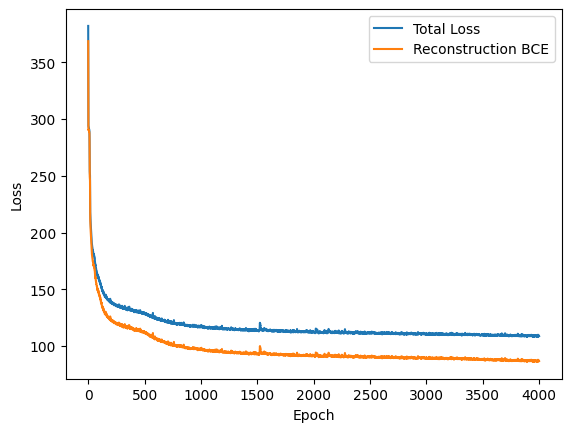

In [22]:


# Use correct keys
loss_history = checkpoint["loss_history"]
bce_history = checkpoint["bce_history"]
kl_smooth_history = checkpoint["kl_smooth_history"]
kl_post_history = checkpoint["kl_post_history"]

# Plot
plt.plot(loss_history, label="Total Loss")
plt.plot(bce_history, label="Reconstruction BCE")
# plt.plot(kl_smooth_history, label="KL Smooth")
# plt.plot(kl_post_history, label="KL Post")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


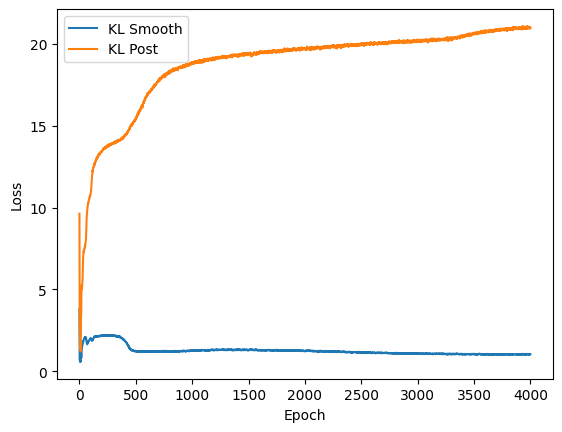

In [23]:

# Plot
#plt.plot(loss_history, label="Total Loss")
#plt.plot(bce_history, label="Reconstruction BCE")
plt.plot(kl_smooth_history, label="KL Smooth")
plt.plot(kl_post_history, label="KL Post")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [24]:
def sample_gaussian(z_mean, z_log_var):
    
    epsilon = torch.randn_like(z_mean)  
    std = torch.exp(0.5 * z_log_var)  
    return z_mean + std * epsilon

torch.Size([20, 1, 32, 32])


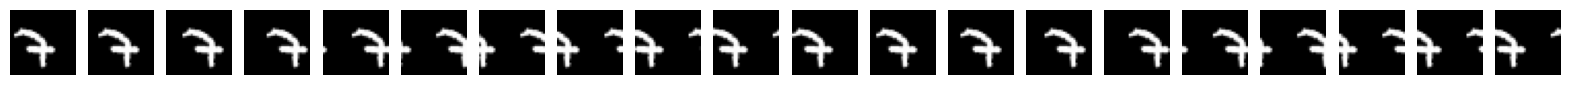

Input batch shape: torch.Size([64, 20, 1, 32, 32])
z shape: torch.Size([64, 20, 15])
zt1 shape: torch.Size([64, 15])
dt_tensor shape: torch.Size([64, 1])
direction_tensor shape: torch.Size([64, 1])
transition_input shape: torch.Size([64, 17])
pt_mean shape: torch.Size([64, 15])
pt_log_var shape: torch.Size([64, 15])
zt2 shape: torch.Size([64, 15])
xt2 shape: torch.Size([64, 1, 32, 32])


In [25]:

batch_size = 64
sequence_length = 20
image_size = 32
num_samples = 500
direction = 1
# Test DataLoader
X_test = MovingMNIST(num_samples, sequence_length=sequence_length, speed=3, digit=8)

test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

for batch in test_loader:
    sequence = dataset[0]
    print(sequence.shape)
    show_sequence(sequence, title="Digit Moves & Wraps Around")
    break


# Get a batch of test sequences
x_test_batch = next(iter(test_loader))  # shape: (B, T, 1, 32, 32)
x_test_batch = x_test_batch.to(device)
print(f"Input batch shape: {x_test_batch.shape}")  # torch.Size([16, 20, 1, 32, 32])

# Forward pass through encoder
t1 = 6
z_mean, z_log_var, z, bt = encoder(x_test_batch) # z shape = (1,20,latent dim)
print("z shape:", z.shape )
zt1 = z[:,t1,:] #(num_samples,latent dim)
print("zt1 shape:", zt1.shape)

for dt in range(1,5):
  #print("dt:", dt)
  t2 = t1 + direction*dt
  #print("t2:", t2)
  dt_tensor = torch.full((batch_size, 1), fill_value=dt, dtype=zt1.dtype, device=device)
  direction_tensor = torch.full((batch_size, 1), fill_value=direction, dtype=zt1.dtype, device=device)
  #print("dt_tensor:", dt_tensor)

  print("dt_tensor shape:", dt_tensor.shape)
  print("direction_tensor shape:", direction_tensor.shape)

  transition_input = torch.cat([zt1, dt_tensor, direction_tensor], dim=-1)
  print("transition_input shape:", transition_input
        .shape)
  pt_mean, pt_log_var = transition(transition_input)

  print("pt_mean shape:", pt_mean.shape)
  print("pt_log_var shape:", pt_log_var.shape)

  zt2 = sample_gaussian(pt_mean, pt_log_var)
  print("zt2 shape:", zt2.shape)
  xt2 = decoder(zt2)
  print("xt2 shape:", xt2.shape)
  break

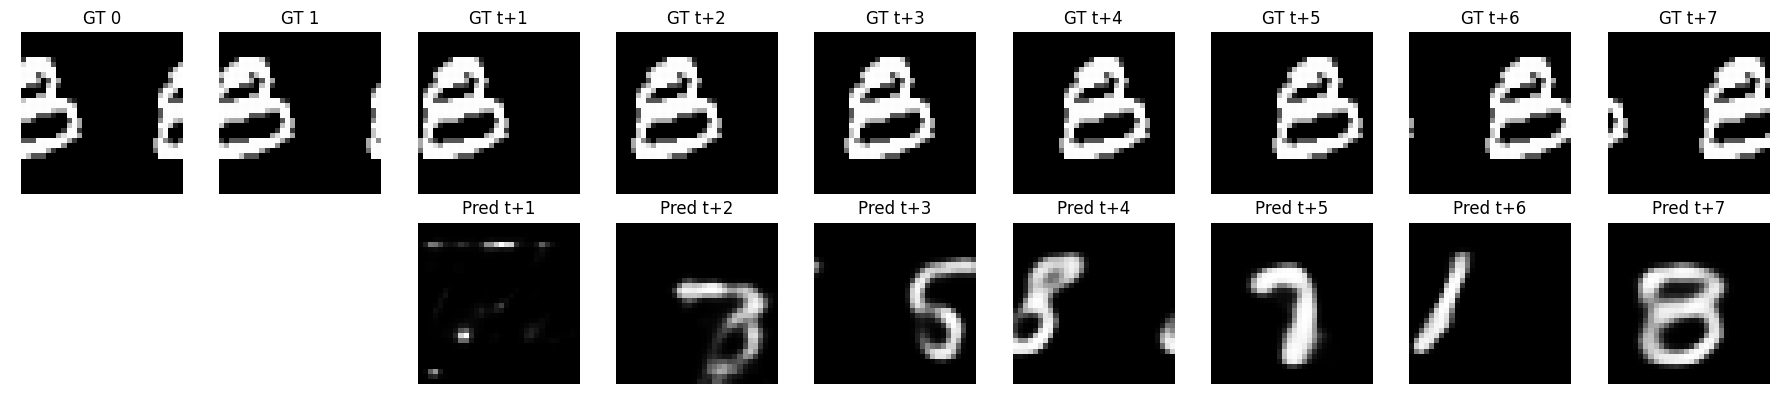

In [26]:
import matplotlib.pyplot as plt
import torch 

t1 = 2
t_end = 8


def to_numpy(img_tensor):
    return img_tensor.detach().cpu().numpy()

def plot_predictions_with_gt(x_test_batch, t1, xt2_list):
    batch_idx = 0  # visualize first sequence
    num_future = len(xt2_list)
    total_cols = t1 + num_future

    fig, axes = plt.subplots(2, total_cols, figsize=(2*total_cols, 4))

    for i in range(total_cols):
        if i < t1:
            axes[0, i].imshow(to_numpy(x_test_batch[batch_idx, i, 0]), cmap='gray')
            axes[0, i].set_title(f"GT {i}")
        else:
            axes[0, i].imshow(to_numpy(x_test_batch[batch_idx, i, 0]), cmap='gray')
            axes[0, i].set_title(f"GT t+{i - t1 + 1}")
        axes[0, i].axis('off')

    for j, pred_frame in enumerate(xt2_list):
        col_idx = t1 + j
        axes[1, col_idx].imshow(to_numpy(pred_frame[batch_idx, 0]), cmap='gray')
        axes[1, col_idx].set_title(f"Pred t+{j+1}")
        axes[1, col_idx].axis('off')

    for i in range(t1):
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

xt2_list = []
for dt in range(1, t_end):
    t2 = t1 + dt
    dt_tensor = torch.full((batch_size, 1), fill_value=dt, dtype=zt1.dtype, device=device)
    direction_tensor = torch.full((batch_size, 1), fill_value=direction, dtype=zt1.dtype, device=device)
    transition_input = torch.cat([zt1, dt_tensor, direction_tensor], dim=-1)
    pt_mean, pt_log_var = transition(transition_input)
    zt2 = sample_gaussian(pt_mean, pt_log_var)
    xt2 = decoder(zt2)  # shape: [B, 1, 32, 32]
    xt2_list.append(xt2)

#Plot Ground truth vs Predicted
plot_predictions_with_gt(x_test_batch, t1, xt2_list)


In [27]:
#Sample next sample from generated sample keeping dt=1 everywhere

# x_test_batch: (B, T, 1, 32, 32)

t1 = 5
z_mean, z_log_var, z, _ = encoder(x_test_batch)  # (B, T, latent_dim)
zt = z[:, t1, :]  # starting/initial latent

predictions = []  # store predicted frames

num_future_steps = 8
direction = 1

for step in range(num_future_steps):
    dt = 1  #Next step
    dt_tensor = torch.full((batch_size, 1), dt, dtype=zt.dtype, device=device)
    direction_tensor = torch.full((batch_size, 1), direction, dtype=zt.dtype, device=device)

    # Transition step
    transition_input = torch.cat([zt, dt_tensor, direction_tensor], dim=-1)
    pt_mean, pt_log_var = transition(transition_input)
    zt = sample_gaussian(pt_mean, pt_log_var)  # this becomes next input

    # Decode
    xt = decoder(zt)
    predictions.append(xt)

# predictions is a list of tensors, each (B, 1, 32, 32)
predictions = torch.stack(predictions, dim=1)  # (B, num_future_steps, 1, 32, 32)


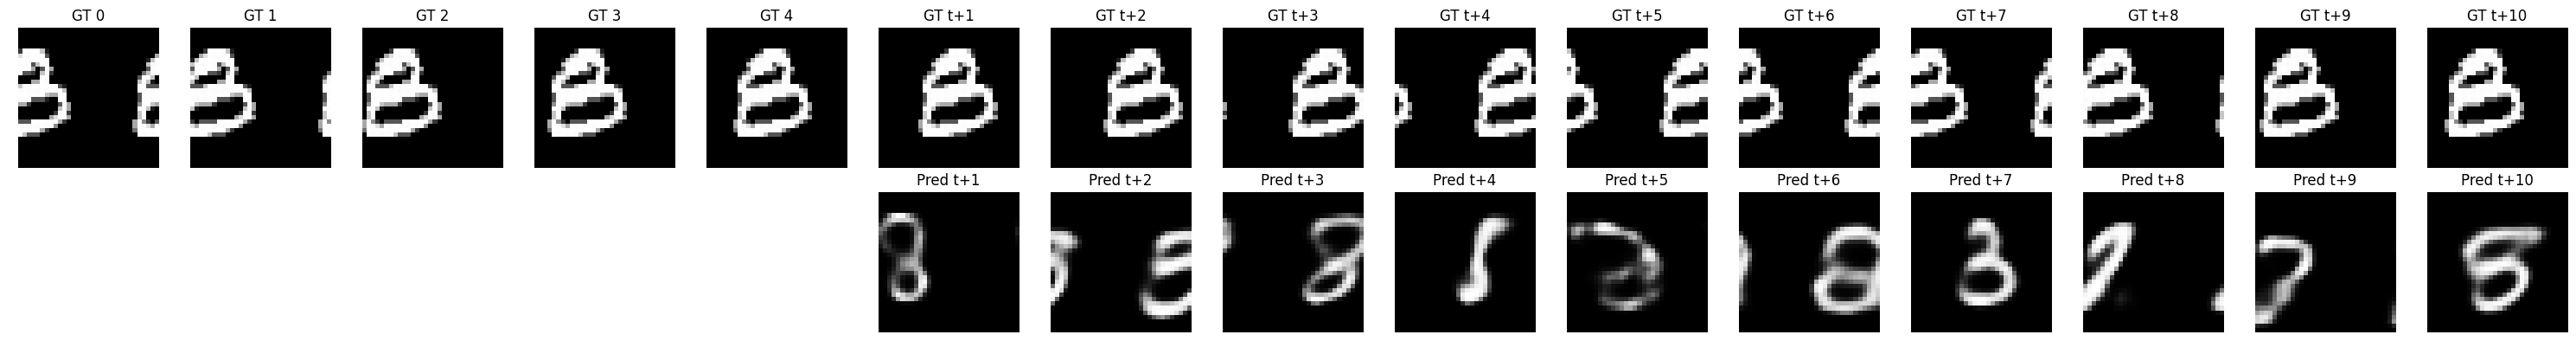

In [28]:
import matplotlib.pyplot as plt

t1 = 5      # starting time step
num_future = 10   # number of future predictions

def to_numpy(img_tensor):
    return img_tensor.detach().cpu().numpy()

def autoregressive_predict(x_test_batch, t1, num_future, direction=1):
    
    # EncodeR 
    z_mean, z_log_var, z, _ = encoder(x_test_batch)  # (B, T, latent_dim)
    zt = z[:, t1, :]  # starting latent

    xt2_list = []

    for _ in range(num_future):
        dt = 1  # next step in each prediction

        dt_tensor = torch.full((batch_size, 1), dt, dtype=zt.dtype, device=device)
        direction_tensor = torch.full((batch_size, 1), direction, dtype=zt.dtype, device=device)

        # Transition
        transition_input = torch.cat([zt, dt_tensor, direction_tensor], dim=1)
        pt_mean, pt_log_var = transition(transition_input)
        zt = sample_gaussian(pt_mean, pt_log_var)  # feed forward next step

        # Decode predicted latent to image
        xt = decoder(zt)  # shape: (B, 1, 32, 32)
        xt2_list.append(xt)

    return xt2_list

# Plotiing
def plot_predictions_with_gt(x_test_batch, t1, xt2_list):
    batch_idx = 0  # visualize first sequence
    num_future = len(xt2_list)
    total_cols = t1 + num_future

    fig, axes = plt.subplots(2, total_cols, figsize=(2*total_cols, 4))

    # Ground truth
    for i in range(total_cols):
        axes[0, i].imshow(to_numpy(x_test_batch[batch_idx, i, 0]), cmap='gray')
        axes[0, i].set_title(f"GT {i}" if i < t1 else f"GT t+{i-t1+1}")
        axes[0, i].axis('off')

    # Predictions
    for j, pred_frame in enumerate(xt2_list):
        col_idx = t1 + j
        axes[1, col_idx].imshow(to_numpy(pred_frame[batch_idx, 0]), cmap='gray')
        axes[1, col_idx].set_title(f"Pred t+{j+1}")
        axes[1, col_idx].axis('off')

    for i in range(t1):
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# ---- Run autoregressive predictions and plot ----
xt2_list = autoregressive_predict(x_test_batch, t1=t1, num_future=num_future, direction=1)
plot_predictions_with_gt(x_test_batch, t1, xt2_list)


#################################################################### END ###############################################################

USe below to resume training 

In [29]:
import os
import torch
import re

checkpoint_dir = "checkpoint_normal_VAE"
num_epochs_total = 4000  # target total epochs

# --- Initialize optimizer ---
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)

# --- Load latest checkpoint ---
latest_epoch = 0
loss_history, bce_history, kl_smooth_history, kl_post_history = [], [], [], []

if os.path.exists(checkpoint_dir):
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith("vae_epoch_") and f.endswith(".pth")]
    
    if checkpoint_files:
        epochs = [int(re.search(r'vae_epoch_(\d+)\.pth', f).group(1)) for f in checkpoint_files]
        latest_epoch = max(epochs)
        checkpoint_path = os.path.join(checkpoint_dir, f"vae_epoch_{latest_epoch}.pth")
        
        print(f"Resuming from checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)

        vae.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        loss_history = checkpoint.get('loss_history', [])
        bce_history = checkpoint.get('bce_history', [])
        kl_smooth_history = checkpoint.get('kl_smooth_history', [])
        kl_post_history = checkpoint.get('kl_post_history', [])
    else:
        print("No checkpoint files found, starting from scratch.")
else:
    print("Checkpoint directory does not exist, starting from scratch.")

#Set starting epoch
start_epoch = latest_epoch

vae.to(device)
vae.train()

print(f"Starting training from epoch {start_epoch+1} to {num_epochs_total}")

#Resume Training Loop
for epoch in range(start_epoch, num_epochs_total):
    total_loss = 0.0
    total_bce = 0.0
    total_kl_smooth = 0.0
    total_kl_post = 0.0
    num_batches = 0

    for batch in train_loader:
        x = batch.to(device)
        beta = cyclic_beta_schedule(step=step, warmup_steps=warmup_epochs)  # choose one schedule
        # OR beta = linear_beta_schedule(epoch, num_epochs_total)

        metrics = vae.train_step(x, optimizer, beta, device)

        total_loss += metrics['loss']
        total_bce += metrics['reconstruction_loss']
        total_kl_smooth += metrics['kl_smoothing_prior']
        total_kl_post += metrics['kl_posterior_transition']
        num_batches += 1

    avg_loss = total_loss / num_batches
    avg_bce = total_bce / num_batches
    avg_kl_smooth = total_kl_smooth / num_batches
    avg_kl_post = total_kl_post / num_batches

    loss_history.append(avg_loss)
    bce_history.append(avg_bce)
    kl_smooth_history.append(avg_kl_smooth)
    kl_post_history.append(avg_kl_post)

    print(f"Epoch {epoch+1}/{num_epochs_total} | "
          f"Beta {beta:.4f} | "
          f"Loss: {avg_loss:.4f} | "
          f"Recon BCE: {avg_bce:.4f} | "
          f"KL Smooth: {avg_kl_smooth:.4f} | "
          f"KL Post: {avg_kl_post:.4f}")

    # Save checkpoint every 50 epochs
    if (epoch + 1) % 50 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"vae_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': vae.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_history': loss_history,
            'bce_history': bce_history,
            'kl_smooth_history': kl_smooth_history,
            'kl_post_history': kl_post_history
        }, checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")


Resuming from checkpoint: checkpoint_normal_VAE\vae_epoch_4000.pth
Starting training from epoch 4001 to 4000


C:\Users\jayan\AppData\Local\Temp\ipykernel_6412\4042858194.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device